当前时间步隐藏变量由当前时间步的输入 与前一个时间步的隐藏变量一起计算得出

 由于在当前时间步中， 隐状态使用的定义与前一个时间步中使用的定义相同， 因此 (8.4.5)的计算是循环的（recurrent）。 于是基于循环计算的隐状态神经网络被命名为 循环神经网络（recurrent neural network）。 在循环神经网络中执行 (8.4.5)计算的层 称为循环层（recurrent layer）。

 这里的相同指参数相同 还是计算公式相同？ 参数相同：

 ，即使在不同的时间步，循环神经网络也总是使用这些模型参数。 因此，循环神经网络的参数开销不会随着时间步的增加而增加

---
计算时用到的性质：我们沿列（轴1）拼接矩阵X和H， 沿行（轴0）拼接矩阵W_xh和W_hh。 这两个拼接分别产生形状 (3,5) 和形状 (5,4) 的矩阵。 再将这两个拼接的矩阵相乘， 我们得到与上面相同形状 (3,4) 的输出矩阵。
---
一个更好的语言模型应该能让我们更准确地预测下一个词元。 因此，它应该允许我们在压缩序列时花费更少的比特。 所以我们可以通过一个序列中所有的 n 个词元的交叉熵损失的平均值来衡量

在基线上，该模型的预测是词表的所有可用词元上的均匀分布。 在这种情况下，困惑度等于词表中唯一词元的数量。

In [72]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)



In [73]:
def get_params(vocab_size,num_hiddens,device):
  num_inputs,num_outputs=vocab_size,vocab_size
  #why no device?
  #because reuse the definition
  def normal(size):
    return torch.randn(size,device=device)*0.01
  #W_xh=torch.normal(0,1,size=(num_inputs,num_hiddens))
  #W_hh=torch.normal(0,1,size=(num_hiddens,num_hiddens))
  W_xh=normal((num_inputs,num_hiddens))
  W_hh=normal((num_hiddens,num_hiddens))
  b_h=torch.zeros(num_hiddens,device=device)

  #W_hq=torch.normal(0,1,size=(num_hiddens,num_outputs))
  W_hq=normal((num_hiddens,num_outputs))
  b_q=torch.zeros(num_outputs,device=device)
  params=[W_xh,W_hh,b_h,W_hq,b_q]
  for param in params:
    param.requires_grad_(True)
  return params

# 模型
为啥加‘，’?
some data(b,state) in device? some(W) not?

In [74]:
#init
def init_rnn_state(batch_size,num_hiddens,device):
  return ((torch.zeros((batch_size,num_hiddens),device=device)),)
#forward_fn
def rnn(inputs,params,state):
  #inputs.shape=(time_step,batch_size,vocab_size) last dim is onehot
  W_xh,W_hh,b_h,W_hq,b_q=params
  H,=state
  outputs=[]
  for X in inputs:
    #print(X.shape,H.shape)
    H=torch.tanh(torch.mm(X,W_xh)+torch.mm(H,W_hh)+b_h)
    Y=torch.mm(H,W_hq)+b_q
    outputs.append(Y)
  return torch.cat(outputs,dim=0),(H,)


#rnn module
class RNNModelScratch:
  def __init__(self,vocab_size,num_hiddens,device,forward_fn,get_params,init_state):
    self.vocab_size,self.num_hiddens=vocab_size,num_hiddens
    self.params=get_params(vocab_size,num_hiddens,device)
    self.forward_fn=forward_fn
    self.init_state=init_state
      
  def __call__(self,X,state):
    #不然会报错
    X=F.one_hot(X.T,self.vocab_size).type(torch.float32)
    return self.forward_fn(X,self.params,state)
  
  def begin_state(self,batch_size,device):
    return self.init_state(batch_size,self.num_hiddens,device)

In [75]:
#pred 续写
def pred(prefix,num_pred,net,vocab,device):
  state=net.begin_state(1,device)
  outputs=[vocab[prefix[0]]]
  #reuse the act of take the last and reshape into tensor(1,1)
  get_input=lambda : torch.tensor(outputs[-1],device=device).reshape((1,1))
  #warmup to make state better
  for y in prefix[1:]:
    _,state=net(get_input(),state)
    outputs.append(vocab.token_to_idx[y])
  #predict
  
  for _ in range(num_pred):
    y,state=net(get_input(),state)
    outputs.append((int)(y.argmax(dim=1).reshape(1)))
  return ''.join(vocab.idx_to_token[c] for c in outputs)

num_hiddens=512
net=RNNModelScratch(len(vocab),num_hiddens,d2l.try_gpu(),rnn,get_params,init_rnn_state)
pred('time traveller',10,net,vocab,d2l.try_gpu())


'time travellerabpt<unk>m bpt'

In [76]:
def grad_clipping(net, theta):  #@save
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

# 训练

困惑度 1.0, 24935.4 词元/秒 cpu
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


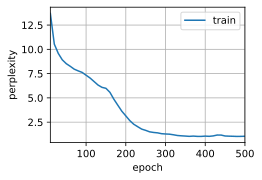

In [77]:
#@save
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
            #print(1,X.shape)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        #print(X.shape)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: pred(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())